# Import modules

In [1]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader


reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Plugins(categories=["generic"]).list()

assert device.type == 'cuda'


/home/bv292/miniconda/envs/test_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reload

In [2]:
import importlib
import DGE_experiments
import DGE_data
import DGE_utils
importlib.reload(DGE_experiments)
importlib.reload(DGE_data)
importlib.reload(DGE_utils)


<module 'DGE_utils' from '/home/bv292/synthcity/DGE_utils.py'>

# Load data and settings

In [3]:
from DGE_data import get_real_and_synthetic

dataset = 'gaussian'  # real data
model_name = 'ctgan'  # synthetic data model

nsyn = 100  # number of synthetic data points per synthetic dataset
p_train = 0.7  # proportion of training data for generative model
n_models = 20  # number of models in ensemble
load = True  # results

load_syn = True  # data
save = True  # save results and data
verbose = False


workspace_folder = "workspace/"+dataset+"/"+model_name
results_folder = "uncertainty_results/"+dataset+"/"+model_name

X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                      p_train=p_train,
                                      n_models=n_models,
                                      model_name=model_name,
                                      load_syn=load_syn,
                                      verbose=verbose)

print(len(X_syns))
print(X_syns[0].shape)


n_total 40000 n_train: 4000
20
(4000, 3)


# Analyses

## Model Training

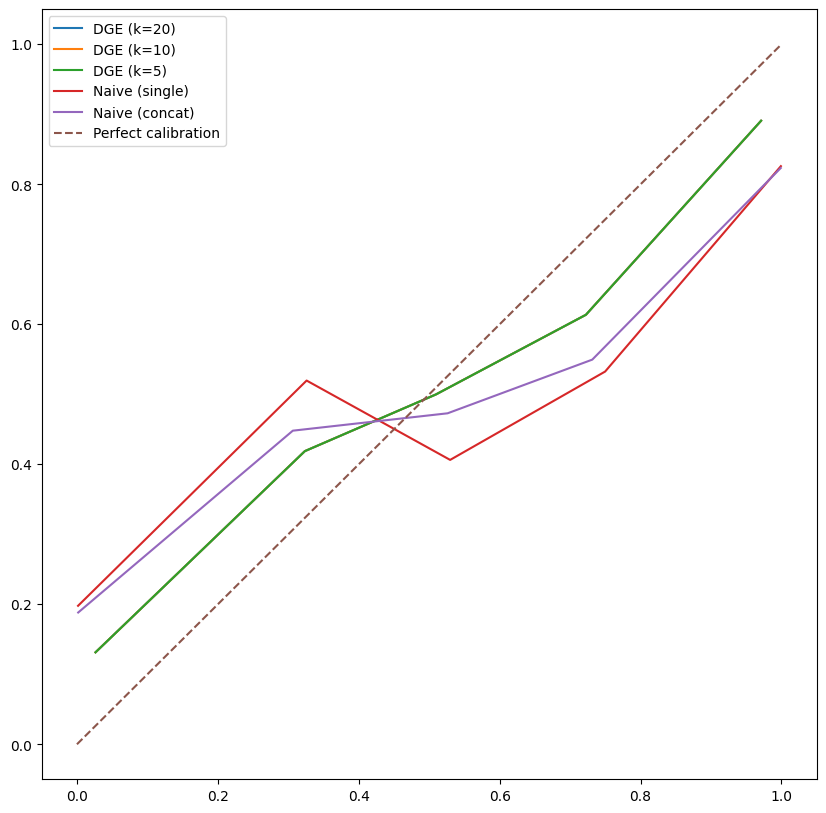

In [4]:
from DGE_experiments import predictive_experiment

predictive_experiment(X_gt,
                      X_syns,
                      workspace_folder=workspace_folder,
                      results_folder=results_folder,
                      save=save,
                      load=load)


## Influence of synthetic data size

Let's study the effect of synthetic data size.

In [5]:
from DGE_experiments import predictive_varying_nsyn

predictive_varying_nsyn(X_gt, X_syns, dataset, model_name, n_models,
                        nsyn, results_folder, workspace_folder, load, save, verbose=True)


## Density estimation


In [6]:
from DGE_experiments import density_experiment

if X_gt.targettype is None:
    density_experiment(X_gt, X_syns, load, save)


# Model Evaluation

We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow.
0. Train and generate synthetic datasets $S_i$.
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic dataset's test set $S_{i,test}$, giving $\hat{M}^S_i$ [Single performance]
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
5. Evaluate on the other synthetic datasets $\cup_{j\neq i} S_{j}$, giving $\hat{M}^G_i$ [Generative performance]
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 
7. Repeat 1-6 for different model classes $f$

N.B. the idea of the above, is that the trained model $f_i$ is the same for each evaluation type. In the model selection section, we will compare the performance of different model classes, where we will train a new model for each evaluation type (hence the aim is to evaluate which class is best, while the model itself may vary).

In [7]:
from DGE_experiments import model_evaluation_experiment

if X_gt.targettype is not None:
    print('Aggregate approaches:')
    res = model_evaluation_experiment(X_gt, X_syns, model_type='mlp')[0]
    print(res)


Aggregate approaches:
             roc_auc      accuracy            f1     precision         recall  \
oracle   79.39 ± 1.8  79.39 ± 1.81   78.89 ± 4.2  81.53 ± 7.15  78.66 ± 12.43   
naive   83.62 ± 1.55  83.74 ± 1.54   83.92 ± 2.1  83.85 ± 2.51   84.03 ± 2.58   
dge     79.18 ± 2.18  79.17 ± 2.25  79.16 ± 4.22   81.0 ± 6.67  79.45 ± 11.98   

                   nll         brier  
oracle  711.86 ± 62.66  20.61 ± 1.81  
naive   561.69 ± 53.32  16.26 ± 1.54  
dge     719.56 ± 77.83  20.83 ± 2.25  


# Model Selection
Essentially repeat the above for different models

In [9]:
from DGE_experiments import model_selection_experiment

if X_gt.targettype is not None:
    results, means_sorted = model_selection_experiment(X_gt, X_syns, relative='l1', metric='accuracy')


Train model 1/20
Train model 2/20
Train model 3/20
Train model 4/20
Train model 5/20
Train model 6/20
Train model 7/20
Train model 8/20
Train model 9/20
Train model 10/20
Train model 11/20
Train model 12/20
Train model 13/20
Train model 14/20
Train model 15/20
Train model 16/20
Train model 17/20
Train model 18/20
Train model 19/20
Train model 20/20
Train model 1/20
Train model 2/20
Train model 3/20
Train model 4/20
Train model 5/20
Train model 6/20
Train model 7/20
Train model 8/20
Train model 9/20
Train model 10/20
Train model 11/20
Train model 12/20
Train model 13/20
Train model 14/20
Train model 15/20
Train model 16/20
Train model 17/20
Train model 18/20
Train model 19/20
Train model 20/20
Train model 1/20
Train model 2/20
Train model 3/20
Train model 4/20
Train model 5/20
Train model 6/20
Train model 7/20
Train model 8/20
Train model 9/20
Train model 10/20
Train model 11/20
Train model 12/20
Train model 13/20
Train model 14/20
Train model 15/20
Train model 16/20
Train model 17/20
T

# Cross validation

We compare the single baseline model vs the generative uncertainty model. Single workflow
1. Take each synthetic dataset $S_i$ and split it up in train and test.
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}$
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.

Versus our baseline
1. Take each synthetic dataset $S_i$ and split it up in train and test
2. Train a model $f_i$ on the train set, for each $S_i$
3. Evaluate on the same synthetic datasets test set $S_{i,test}
4. Evaluate on the true real test set (oracle), $D_{test}$, giving $\hat{M}_i$
5. Average results across the different synthetic datasets, giving $M_i$.
6. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average.


Cross-validation approach to test which type of model would perform best on real data. We compare the single baseline model vs the generative uncertainty model vs an oracle. Workflow Cross-validation.
0. Train and generate synthetic datasets $S_i$.
1. Use CV to train and evaluate models $f_i$ on each $S_i$. Repeat for all $S_i$. [Single performance]
2. Use CV \textit{over datasets $S_i$} (i.e. train on all but one $S_i$, evaluate on remaining and repeat) to train and evaluate models $f_i$.
3. For both cases, evaluate the model also on the true real test set (oracle), $D_{test}$, giving $M_i$ [Oracle performance]
4. Compute the deviation from the oracle, $||M_i - \hat{M}_i||$ and average over all models $f_i$. 

# Model parameter estimation
Using a linear model

# Calibration

In [ ]:
from sklearn.calibration import calibration_curve


#prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=3)
